In [203]:
from brian2 import *
%matplotlib inline

In [204]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

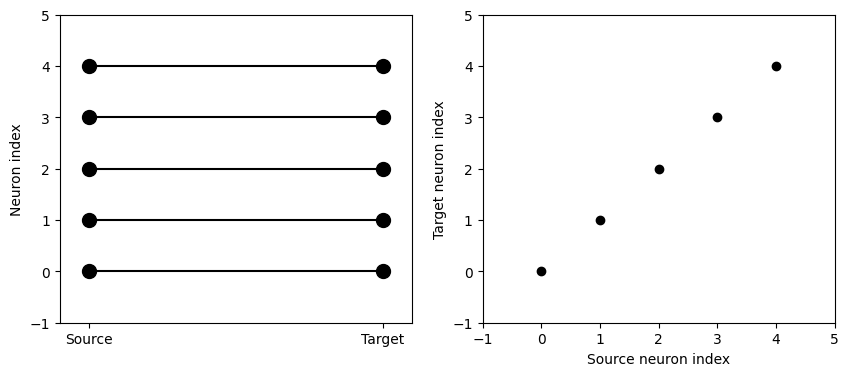

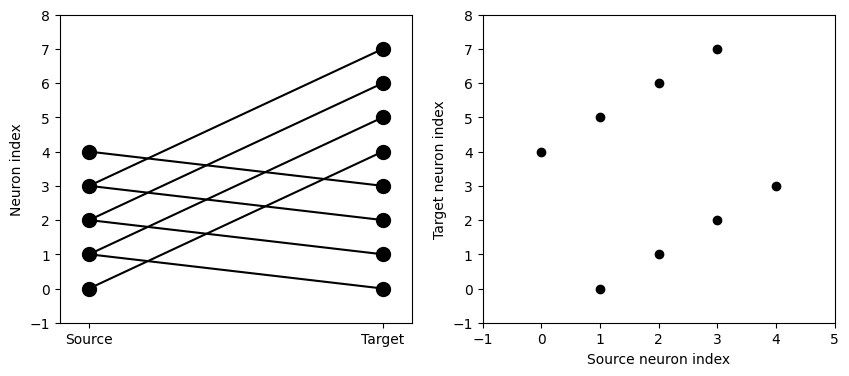

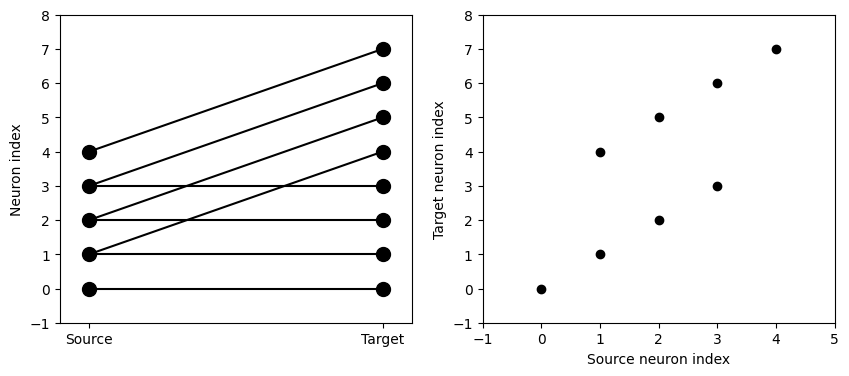

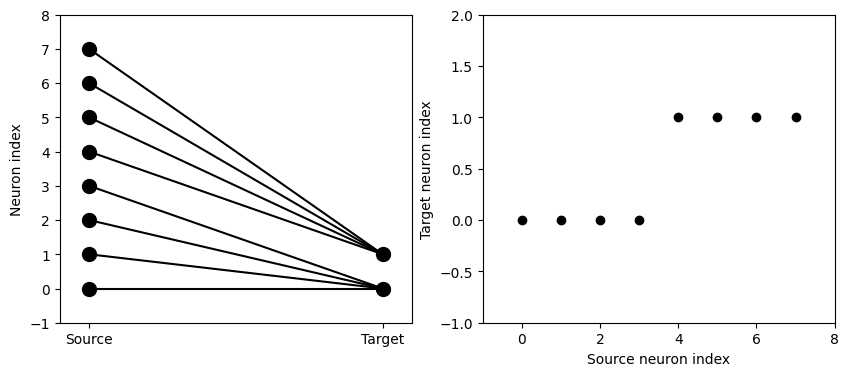

In [205]:
start_scope() 
# Init the neuron voltage equation and parementers
tau_mem = 20*ms
tau_syn = 2*ms
v_rest = -70*mV
R = 100*Mohm
I_weight = 3*nA
eqs = '''
dv/dt = (v_rest - v + R*I_syn) / tau_mem : volt (unless refractory)
dI_syn/dt = -I_syn/tau_syn : ampere
'''
thres = 'v>-55*mV'
reset = 'v=-80*mV'
refract_time = 2*ms

# Init the spikes
spike_delay = 12*ms
# spikes_indices = [0,1,2,3,4] # left to right input
# spikes_indices = [4,3,2,1,0] # right to left input
spikes_indices = [0,1,2,3,4,3,2,1,0,1,2,3,4] # left to right to left to right input
spikes_times = [i*spike_delay for i in range(0, len(spikes_indices))]

# Create the layers
Input = SpikeGeneratorGroup(5, spikes_indices, spikes_times)
FFInhib = NeuronGroup(5, eqs, threshold=thres, reset=reset, refractory=refract_time, method='exact')
Relay = NeuronGroup(8, eqs, threshold=thres, reset=reset, refractory=refract_time, method='exact')
Output = NeuronGroup(2, eqs, threshold=thres, reset=reset, refractory=refract_time, method='exact')
# FFInhib = NeuronGroup(4, eqs, threshold=thres, reset=reset, refractory=refract_time, method='exact')
# Relay = NeuronGroup(4, eqs, threshold=thres, reset=reset, refractory=refract_time, method='exact')
# Output = NeuronGroup(1, eqs, threshold=thres, reset=reset, refractory=refract_time, method='exact')

# Set neuron voltage to resting before running the simulation
FFInhib.v = v_rest
Relay.v = v_rest
Output.v = v_rest

# Synapse connections
InputToFFI = Synapses(Input, FFInhib, on_pre='I_syn += I_weight')
InputToFFI.connect(condition='i==j')
visualise_connectivity(InputToFFI)

InputToRelay = Synapses(Input, Relay, on_pre='I_syn += I_weight')
InputToRelay.connect(condition='i+4==j or i-1==j')
visualise_connectivity(InputToRelay)

FFIToRelay = Synapses(FFInhib, Relay, on_pre='I_syn += -I_weight')
FFIToRelay.connect(condition='(i==j and i<4) or (i+3==j and i>0)')
visualise_connectivity(FFIToRelay)

RelayToOutput = Synapses(Relay, Output, on_pre='I_syn += I_weight/3')
RelayToOutput.connect(condition='(i-4<0 and j==0) or (i-4>=0 and j==1)')
visualise_connectivity(RelayToOutput)

#Monitor all neurons
monitorInput = SpikeMonitor(Input, record=True)
monitorFFI = StateMonitor(FFInhib, ['v', 'I_syn'], record=True)
monitorRelay = StateMonitor(Relay, ['v', 'I_syn'], record=True)
monitorOutput = StateMonitor(Output, ['v', 'I_syn'], record=True)

run(spike_delay * len(spikes_indices))

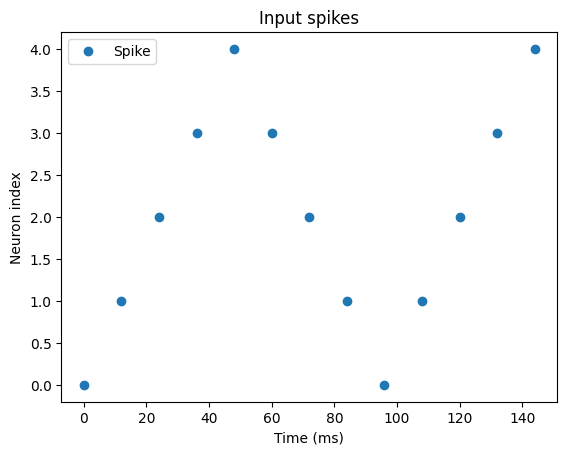

In [206]:
plot(monitorInput.t/ms, monitorInput.i[:], 'o',label='Spike')
xlabel('Time (ms)')
ylabel('Neuron index')
title('Input spikes')
legend();

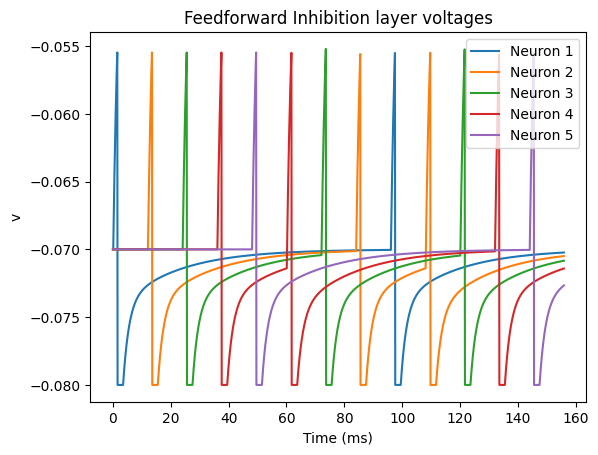

In [207]:
plot(monitorFFI.t/ms, monitorFFI.v[0], label='Neuron 1')
plot(monitorFFI.t/ms, monitorFFI.v[1], label='Neuron 2')
plot(monitorFFI.t/ms, monitorFFI.v[2], label='Neuron 3')
plot(monitorFFI.t/ms, monitorFFI.v[3], label='Neuron 4')
plot(monitorFFI.t/ms, monitorFFI.v[4], label='Neuron 5')
xlabel('Time (ms)')
ylabel('v')
title('Feedforward Inhibition layer voltages')
legend();

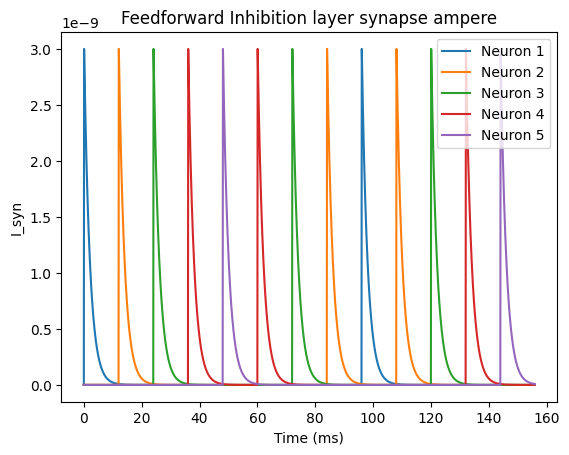

In [208]:
plot(monitorFFI.t/ms, monitorFFI.I_syn[0], label='Neuron 1')
plot(monitorFFI.t/ms, monitorFFI.I_syn[1], label='Neuron 2')
plot(monitorFFI.t/ms, monitorFFI.I_syn[2], label='Neuron 3')
plot(monitorFFI.t/ms, monitorFFI.I_syn[3], label='Neuron 4')
plot(monitorFFI.t/ms, monitorFFI.I_syn[4], label='Neuron 5')
xlabel('Time (ms)')
ylabel('I_syn')
title('Feedforward Inhibition layer synapse ampere')
legend();

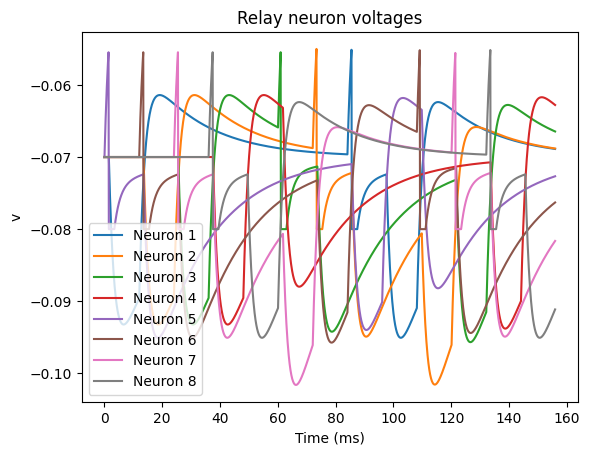

In [209]:
plot(monitorRelay.t/ms, monitorRelay.v[0], label='Neuron 1')
plot(monitorRelay.t/ms, monitorRelay.v[1], label='Neuron 2')
plot(monitorRelay.t/ms, monitorRelay.v[2], label='Neuron 3')
plot(monitorRelay.t/ms, monitorRelay.v[3], label='Neuron 4')
plot(monitorRelay.t/ms, monitorRelay.v[4], label='Neuron 5')
plot(monitorRelay.t/ms, monitorRelay.v[5], label='Neuron 6')
plot(monitorRelay.t/ms, monitorRelay.v[6], label='Neuron 7')
plot(monitorRelay.t/ms, monitorRelay.v[7], label='Neuron 8')
xlabel('Time (ms)')
ylabel('v')
title('Relay neuron voltages')
legend();

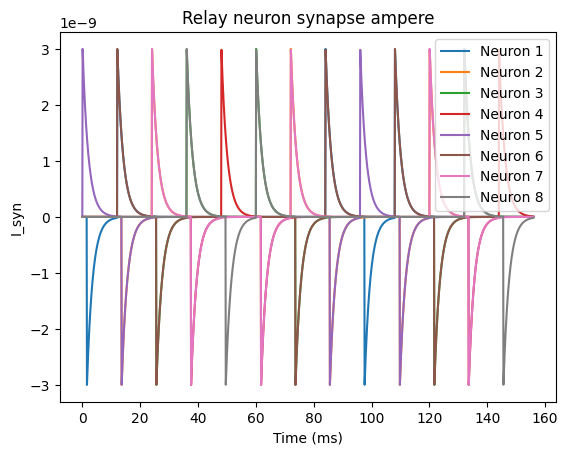

In [210]:
plot(monitorRelay.t/ms, monitorRelay.I_syn[0], label='Neuron 1')
plot(monitorRelay.t/ms, monitorRelay.I_syn[1], label='Neuron 2')
plot(monitorRelay.t/ms, monitorRelay.I_syn[2], label='Neuron 3')
plot(monitorRelay.t/ms, monitorRelay.I_syn[3], label='Neuron 4')
plot(monitorRelay.t/ms, monitorRelay.I_syn[4], label='Neuron 5')
plot(monitorRelay.t/ms, monitorRelay.I_syn[5], label='Neuron 6')
plot(monitorRelay.t/ms, monitorRelay.I_syn[6], label='Neuron 7')
plot(monitorRelay.t/ms, monitorRelay.I_syn[7], label='Neuron 8')
xlabel('Time (ms)')
ylabel('I_syn')
title('Relay neuron synapse ampere')
legend();

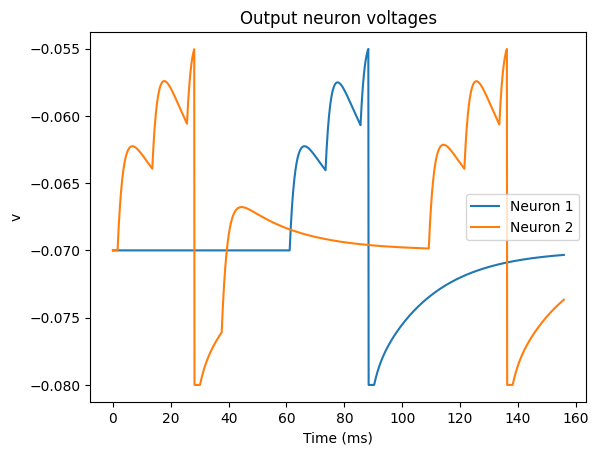

In [211]:
plot(monitorOutput.t/ms, monitorOutput.v[0], label='Neuron 1')
plot(monitorOutput.t/ms, monitorOutput.v[1], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
title('Output neuron voltages')
legend();

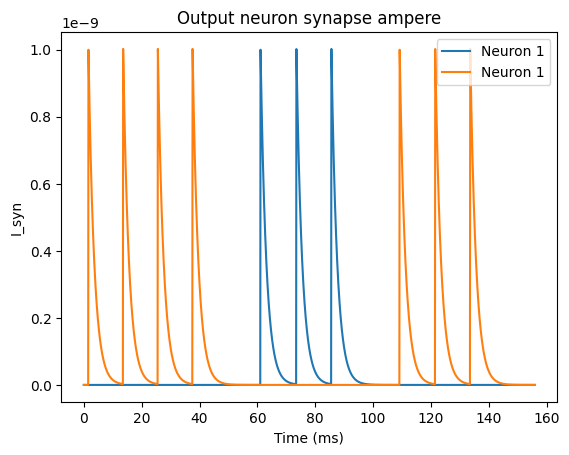

In [212]:
plot(monitorOutput.t/ms, monitorOutput.I_syn[0], label='Neuron 1')
plot(monitorOutput.t/ms, monitorOutput.I_syn[1], label='Neuron 1')
xlabel('Time (ms)')
ylabel('I_syn')
title('Output neuron synapse ampere')
legend();